# Исследование гипотез

В онлайн-магазине отделы маркетинга и аналитики подготовили список гипотез для увеличения выручки магазина. 

**Цель:**

- Приоритезация гипотез;
- Анализ результатов A/B-теста;

**Задачи:**

- Загрузка данных и подготовка их к анализу;
- Приоритезация гипотез по фреймворкам ICE и RICE, изучение различий в рейтингах гипотез;
- Анализ результатов A/B-теста через построение линейных графиков, точечных графиков, расчета 95-й и 99-й перцентилей, статистических различий метрик по группам с "сырыми" и "очищенными" от выбросов данными с помощью метода Уилкоксона-Манна-Уитни.
- Выводы о наличии/отсутствии различия между метриками групп А и B, вывод о необходимости окончания или продолжения теста;

**Описание данных:**

Файл /datasets/hypothesis.csv:

    Hypothesis — краткое описание гипотезы;
    Reach — охват пользователей по 10-балльной шкале;
    Impact — влияние на пользователей по 10-балльной шкале;
    Confidence — уверенность в гипотезе по 10-балльной шкале;
    Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл /datasets/orders.csv:

    transactionId — идентификатор заказа;
    visitorId — идентификатор пользователя, совершившего заказ;
    date — дата, когда был совершён заказ;
    revenue — выручка заказа;
    group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv:

    date — дата;
    group — группа A/B-теста;
    visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Загрузка и подготовка данных к анализу

Загрузим, изучим и подготовим данные к анализу.

In [258]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [259]:
try:
    hypothesis, orders, visitors = (
    pd.read_csv('hypothesis.csv'),
    pd.read_csv('orders.csv'),
    pd.read_csv('visitors.csv')
)
except:
    hypothesis, orders, visitors = (
    pd.read_csv('/datasets/hypothesis.csv'),
    pd.read_csv('/datasets/orders.csv'),
    pd.read_csv('/datasets/visitors.csv')
)

Исправим названия столбцов (переведем в нижний регистр.)

In [260]:
hypothesis.columns = hypothesis.columns.str.lower()

In [261]:
orders = orders.rename(
    columns={
        'transactionId':'transaction_id',
        'visitorId':'visitor_id'
    }
)

Преобразуем данные в нужный тип

In [262]:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

Проверим наличие полных дублей

In [263]:
hypothesis.duplicated().sum()

0

In [264]:
orders.duplicated().sum()

0

In [265]:
visitors.duplicated().sum()

0

Проверим данные на пропуски

In [266]:
hypothesis.isnull().sum()

hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64

In [267]:
orders.isnull().sum()

transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64

In [268]:
visitors.isnull().sum()

date        0
group       0
visitors    0
dtype: int64

Результаты изучения данных:
- Обнаружены и исправлены ошибки в названиях столбцов;
- Данные приведены к нужному типу;
- Дубликаты не обнаружены;
- Пропусков данных нет;

## Приоритезация гипотез

Применим фреймворки ICE и RICE для приоритизации гипотез

In [269]:
hypothesis['ice'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
pd.options.display.max_colwidth = 120
display(hypothesis.head(10).sort_values(by='ice', ascending=False))

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000


In [270]:
hypothesis['rice'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
pd.options.display.max_colwidth = 120
display(hypothesis.head(10).sort_values(by='rice', ascending=False))

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


Применив 2 разных фреймворка для оценки гипотез мы видим изменение рейтингов гипотез. В случае ICE на первом месте гипотеза 8, в пятерке гипотез - 0, 7, 6, 2. В случае RICE на первое место выходит 7я, в пятерке - 2, 0, 6, 8, т.е. 8я гипотеза спустилась на несколько позиций ниже. Причина - учет параметра Reach (охвата) во второй формуле. 

И действительно: добавление формы подписки коснется бОльшего количества пользователей, чем акция на скидку в день рождения. Добавим, что при использовании первого фреймворка на первый план выходят гипотезы, связанные с рекламой и маркетинговыми акциями, а во втором лучае - то, что касается сайта магазина.

## Анализ A/B-теста

Проверим, есть ли пересечение групп А и B по пользователям. Если такие общие пользователи найдутся, эти ID удалим из анализа.

In [271]:
orders_a = orders.query('group == "A"')
orders_b = orders.query('group == "B"')
orders_id = orders_a.merge(orders_b, on='visitor_id', how='inner')
display(orders_id.head(10))

,transaction_id_x,visitor_id,date_x,revenue_x,group_x,transaction_id_y,date_y,revenue_y,group_y
0,2961555356,4069496402,2019-08-15,400,A,1473132782,2019-08-12,640,B
1,2223239646,199603092,2019-08-15,3488,A,437656952,2019-08-02,3488,B
2,62794304,199603092,2019-08-22,6976,A,437656952,2019-08-02,3488,B
3,2971973105,199603092,2019-08-27,2790,A,437656952,2019-08-02,3488,B
4,1941707234,199603092,2019-08-12,6438,A,437656952,2019-08-02,3488,B
5,2220299125,3803269165,2019-08-15,700,A,473864496,2019-08-23,2360,B
6,2220299125,3803269165,2019-08-15,700,A,3244441077,2019-08-09,590,B
7,2220299125,3803269165,2019-08-15,700,A,2860596918,2019-08-14,6613,B
8,2220299125,3803269165,2019-08-15,700,A,3898641900,2019-08-14,790,B
9,486237576,2378935119,2019-08-15,1650,A,2213813903,2019-08-25,21220,B


In [272]:
orders_id_unique = orders_id['visitor_id'].unique()
len(orders_id_unique)

58

In [273]:
orders = orders[~orders['visitor_id'].isin(orders_id_unique)]
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


Построим и изучим график кумулятивной выручки по группам

In [274]:
datesGroups = orders[['date','group']].drop_duplicates()

In [275]:
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

ordersAggregated.head(5)

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854


In [276]:
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated.head(5)

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [277]:
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
# cumulativeData

In [278]:
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]
# cumulativeData

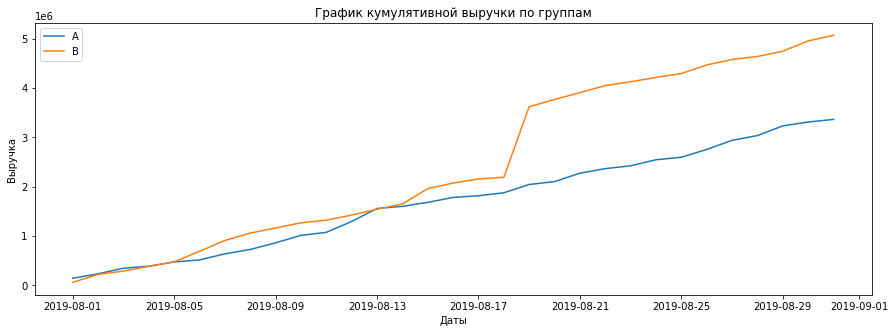

In [279]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(15, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title("График кумулятивной выручки по группам")
plt.xlabel("Даты")
plt.ylabel("Выручка")
plt.legend();


В середине августа в группе B резко выросла кумулятивная выручка. Показатели группы А после этой даты ниже выручки В, и растут линейно, без скачков. Вероятная причина скачка у группы В - увеличение количества заказов либо рост среднего чека.

Построим и изучим график кумулятивного среднего чека по группам

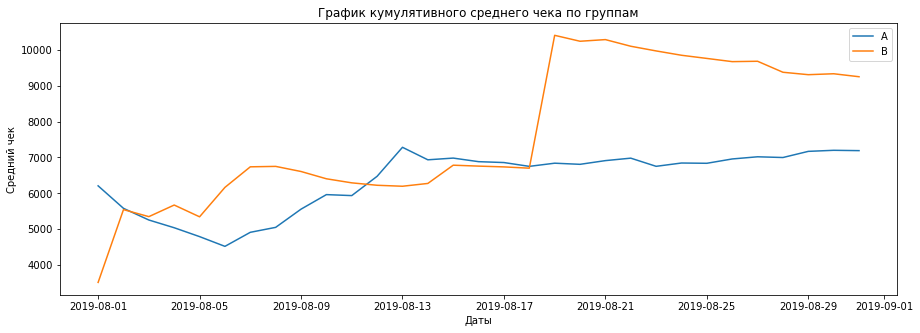

In [280]:
plt.figure(figsize=(15, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title("График кумулятивного среднего чека по группам")
plt.xlabel("Даты")
plt.ylabel("Средний чек")
plt.legend();

У группы А - колебание среднего чека, причем на старте группа А опережает по чеку группу В, потом спад (и показатели групп меняются местами), потом у группы А рост до первой недели августа и после этого средний чек фиксируется примерно около однго значения. У группы В - рост после начала августа, а потом резкий скачок в середине августа (который и привел к росту выручки на предыдущем графике.) Т.о. причина роста выручки у группы В - скачок размера среднего чека. 

Построим и изучим график относительного изменения кумулятивного среднего чека группы B к группе A

In [281]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, left_on='date', 
    right_on='date', how='left', suffixes=['A', 'B']
)
#mergedCumulativeRevenue

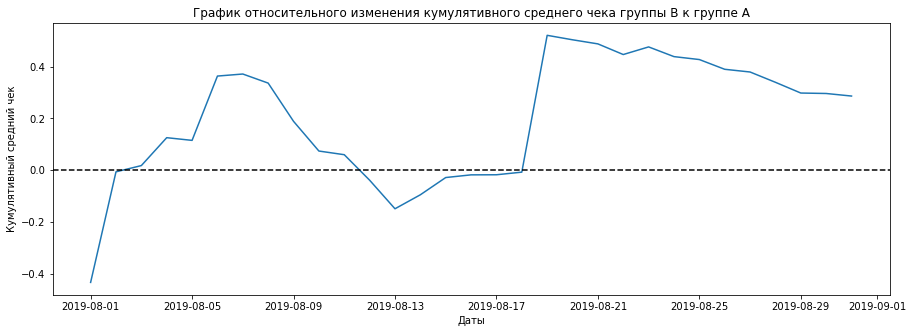

In [282]:
plt.figure(figsize=(15, 5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.title("График относительного изменения кумулятивного среднего чека группы B к группе A")
plt.xlabel("Даты")
plt.ylabel("Кумулятивный средний чек")
plt.axhline(y=0, color='black', linestyle='--');

Дважды средний чек группы В растет по отношению к чеку группы А - в конце 1-й недели августа, и после 17 августа. По большей части группа В оеперажает группу А.

Построим и изучим график кумулятивной конверсии по группам

In [283]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

In [284]:
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

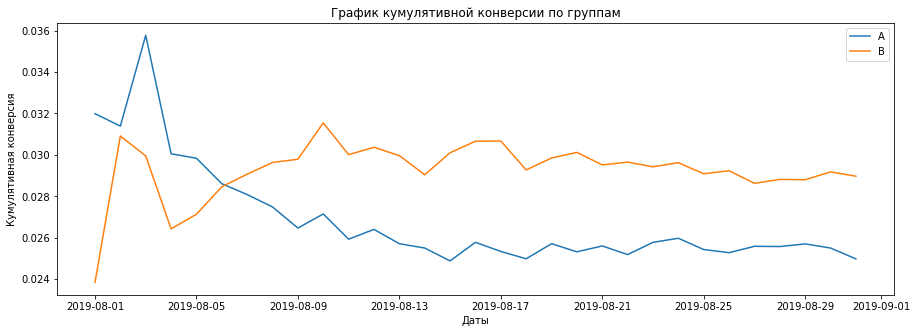

In [285]:
plt.figure(figsize=(15, 5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title("График кумулятивной конверсии по группам")
plt.xlabel("Даты")
plt.ylabel("Кумулятивная конверсия")
plt.legend();

После пика в начале августа конверсия группы А падает до определенного уровня и колеблется на этом уровне уже до конца периода. В другом направлении, практически зеркально, двигается конверсия группы В: после первого пика спад, но потом рост до 10-х чисел августа и потом колебания в относительно небольшом диапазоне. Конверсия при этом выше показателей группы А. Поскольку конверсия группы В стабильна, причина роста выручки этой группы на фоне роста среднего чека - в крупных заказах после 17 августа. 

Построим и изучим график относительного изменения кумулятивной конверсии группы B к группе A

In [286]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
    cumulativeDataB[['date','conversion']], left_on='date', 
    right_on='date', how='left', suffixes=['A', 'B']
)

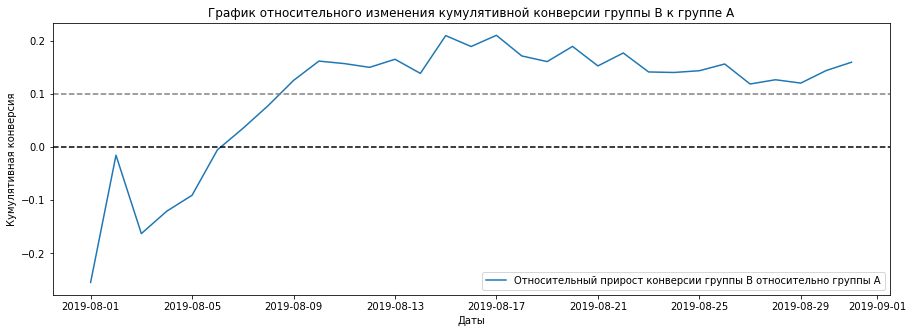

In [287]:
plt.figure(figsize=(15, 5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.title("График относительного изменения кумулятивной конверсии группы B к группе A")
plt.xlabel("Даты")
plt.ylabel("Кумулятивная конверсия")
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--');


Здесь также виден рост конверсии группы В относительно метрики группы А с небольшим снижением этого соотношения после 20-х чисел августа.

Построим и изучим точечный график количества заказов по пользователям, посчитаем 95-й и 99-й перцентили количества заказов на пользователя

In [288]:
orders_sum = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

orders_sum.columns = ['visitor_id', 'orders_count']

print(orders_sum['orders_count'].value_counts()) 

1    937
2     29
3      7
Name: orders_count, dtype: int64


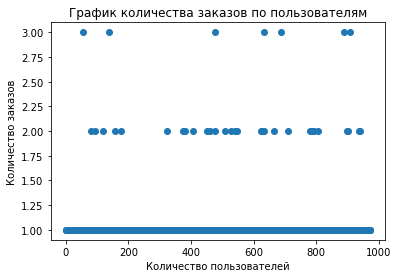

In [289]:
x_values_orders = pd.Series(range(0,len(orders_sum['orders_count'])))
plt.scatter(x_values_orders, orders_sum['orders_count'])
plt.title("График количества заказов по пользователям")
plt.xlabel("Количество пользователей")
plt.ylabel("Количество заказов");

In [290]:
print(np.percentile(orders_sum['orders_count'], [90, 95, 99]))

[1. 1. 2.]


95% юзеров делают 1 заказ. а значит это и есть граница аномальных пользователей. 

Построим и изучим точечный график стоимостей заказов, посчитаем 95-й и 99-й перцентили стоимости заказов

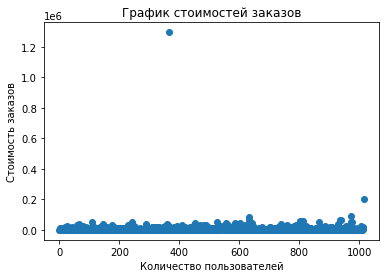

In [291]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title("График стоимостей заказов")
plt.xlabel("Количество пользователей")
plt.ylabel("Стоимость заказов");

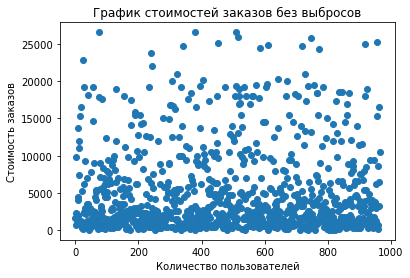

In [292]:
y_values = orders.query('revenue < 26785')
x_values = pd.Series(range(0,len(y_values['revenue'])))
plt.scatter(x_values, y_values['revenue'])
plt.title("График стоимостей заказов без выбросов")
plt.xlabel("Количество пользователей")
plt.ylabel("Стоимость заказов");


In [293]:
print(np.percentile(orders['revenue'], [90, 95, 99])) 

[17990. 26785. 53904.]


95% пользователей делают заказ на сумму до 26785 р., а значит граница "аномальных" заказов - 26785 тр.

Посчитаем **статистическую значимость различий в конверсии** между группами по **«сырым»** данным

In [294]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

In [295]:
sampleA = pd.concat([ordersByUsersA['orders']\
    ,pd.Series(0, index=np.arange(visitors[visitors['group']=='A']['visitors']\
    .sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders']\
    ,pd.Series(0, index=np.arange(visitors[visitors['group']=='B']['visitors']\
    .sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

H0: различий в конверсии между группами нет.

H1: различия в конверсии между группами есть.

Гипотезы будут проверяться непараметрическим тестом Уилкоксона-Манна-Уиттни, уровень значимости - 0.05.

In [296]:
print('p-value:', "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Относительный прирост среднего числа заказов группы B:', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value: 0.011
Относительный прирост среднего числа заказов группы B: 0.160


Поскольку p-value меньше 0.05, поэтому мы отвергаем нулевую гипотезу, и мы наблюдаем статистически значимую разницу в конверсии. Конверсия группы В выше конверсии группы А.

Посчитаем **статистическую значимость различий в среднем чеке** заказа между группами по **«сырым»** данным

H0: различий в среднем чеке между группами нет. 

H1: различия в среднем чеке между группами есть.

Гипотезы будут проверяться непараметрическим тестом Уилкоксона-Манна-Уиттни, уровень значимости - 0.05.

In [297]:
print('p-value:', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительный прирост среднего чека группы B:','{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value: 0.829
Относительный прирост среднего чека группы B: 0.287


p-value значительно выше 0.05, а значит нулевую гипотезу мы отвергнуть не можем. По второму показателю средний чек группы В выше среднего чека группы А. Существенная относительная разница при отсутствии статистической значимости указывает на влияние выбросов на метрику.

Посчитаем **статистическую значимость различий в конверсии** между группами по **«очищенным»** данным

In [298]:
abnormal_orders_quantity = 1
abnormal_revenue = 26785

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > abnormal_orders_quantity]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > abnormal_orders_quantity]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > abnormal_revenue]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0]) 

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
Name: visitor_id, dtype: int64
86


In [299]:
sampleAFiltered = pd.concat(
    [ordersByUsersA[np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))]['orders'],pd.Series(0,index=np.arange(visitors[visitors['group']=='A']['visitors'].sum() - len(ordersByUsersA['orders'])),name='orders',),],axis=0,)


sampleBFiltered = pd.concat(
    [ordersByUsersB[np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))]['orders'],pd.Series(0,index=np.arange(visitors[visitors['group']=='B']['visitors'].sum() - len(ordersByUsersB['orders'])),name='orders',),],axis=0,)

H0: различий в конверсии между группами с "очищенными" данными нет.

H1: различия в конверсии между группами с "очищенными" данными есть.

Гипотезы будут проверяться непараметрическим тестом Уилкоксона-Манна-Уиттни, уровень значимости - 0.05.

In [300]:
print('p-value:', '{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print(
    'Относительный прирост среднего числа заказов группы B после удаления выбросов:', '{0:.3f}'
    .format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)
)

p-value: 0.016
Относительный прирост среднего числа заказов группы B после удаления выбросов: 0.174


p-value ниже 0.05, поэтому в случае изучения "очищенных" от выбросов данных мы отвергаем нулевую гипотезу. Конверсия группы В при этом выше конверсии группы А, и по сравнению с сырыми данными выросла на 1,4%

Посчитаем **статистическую значимость различий в cреднем чеке** заказа между группами по **«очищенным»** данным

H0: различий в среднем чеке между группами с "очищенными" данными нет.

H1: различия в среднем чеке между группами с "очищенными" данными есть.

Гипотезы будут проверяться непараметрическим тестом Уилкоксона-Манна-Уиттни, уровень значимости - 0.05.

In [301]:
print(
    'p-value:', '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    'Относительный прирост среднего чека группы B после удаления выбросов:',"{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value: 0.727
Относительный прирост среднего чека группы B после удаления выбросов: -0.034


p-value значительно больше 0.05, поэтому отвергнуть нулевую гипотезу после исключения из группы выборосов мы не можем. При этом после очистки данных средний чек группы В оказывается ниже чека группы А, "падение" составило 34% 

## Общие выводы

- В зависимости о методики расчета приоритеты гипотез меняются (изменения при этом внутри топ-5). Во втором случае (RICE) на первое место попадает гипотеза о добавлении формы подписки (т.к. она коснется бОльшего количества пользователей), а рекордсмен 1-го расчета (акция на скидку в день рождения) сместилась на 5-е место в этомтопе.
- В А/В тестировании нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий. При этом после очистки данных соотношение средних чеков изменилось в пользу группы А;
- При этом есть разница в конверсии между группами есть и при расчетах "сырых" данных и после очистки данных от выбросов;
- По сделанным выводам мы бы рекомендовали остановить тест и признать победу группы В: хотя выбросы и влияют на размер чека группы В, но количество заказов у группы В статистически значимо больше, а значит различие между этими группами приводит к разнице экономических показателей. 